# Reading in our own dataset

We previously defined a dataset of pictures of digits and saved it in a file named "digits.data". The format is:

```
0 1 1 1 1 0 
1 0 0 0 0 1 
1 0 0 0 0 1 
1 0 0 0 0 1 
1 0 0 0 0 1 
0 1 1 1 1 0 

```

where 1 represents part of a line of the digit, and 0 is empty. The example above represents a zero.

Each picture of a digit is 6 x 6 "pixels"
and there are 24 of each digit in order, 0 through 9. This gives us a total of 240 pictures.

We read in the data, and create a numpy array containing all of the input data.

In [1]:
import numpy as np

In [2]:
def get_digit_inputs():
    """Each digit is represented by a 6x6 grid of 1's and 0's separated by blank lines."""
    fp = open("digits.data", "r")
    data = []
    while True:
        digit = []
        line = fp.readline()
        while len(line) != 0 and (line[0] == '0' or line[0] == '1'):
            line.strip()
            values = line.split()
            digit += [int(v) for v in values]
            line = fp.readline()
        if len(line) == 0:
            break
        if len(digit) > 0:
            data.append(digit)
    return np.array(data)

In [3]:
inputs = get_digit_inputs()
inputs.shape

(240, 36)

We create a "one hot" target pattern for each digit so that a picture of a zero has a target of:

```
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
```

And a picture of a one has a target of:

```
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
```

And so on.

In [4]:
def one_hot(length, index):
    vec = [0]*length
    vec[index] = 1
    return vec

In [5]:
def get_digit_targets(n):
    """Create n repetitions of 10 one-hot vectors"""
    data = []
    for i in range(n):
        for j in range(10):
            data.append(one_hot(10, j))
    return np.array(data)

In [6]:
targets = get_digit_targets(24)
targets.shape

(240, 10)

# Training a network

Now that the data is prepared, we are ready to train a network to learn this task.

In [7]:
from aitk.networks import SimpleNetwork

In [8]:
def build_model():
    net = SimpleNetwork(36, (8, "sigmoid"), (10, "softmax"),
        loss = "categorical_crossentropy",
        metrics = ["tolerance_accuracy"]
        )
    net.set_config_layer("input", vshape=(6,6,1), colormap=("gray",0,1))
    net.set_learning_rate(0.1)
    net.set_momentum(0.0)
    return net                  

In [9]:
net = build_model()
net.set_tolerance(0.2)

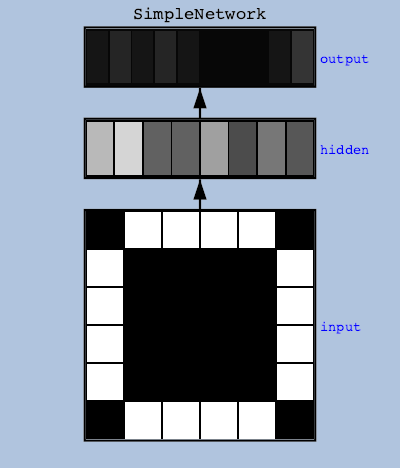

In [11]:
net.take_picture(inputs[0], scale=0.50, format="image")

# Tracking PCA at each layer throughout training

Here we will show a Principal Component Analysis plot at each layer, before training.

We first need a color for each input. Since our dataset is 0 through 9 repeating,
we can just use 10 random colors, repeating 24 times:

In [12]:
colors = ["pink", "red", "orange", "yellow", "green", 
          "teal", "blue", "indigo", "violet", "black"] * 24

Now, we call predict_pca with the the entire input dataset. 

<div class="alert alert-block alert-info">
    <b>Note</b>: every time we call predict_pca() it will compute new Eigenvalues for the PCA space, unless we instruct it not to.
</div>


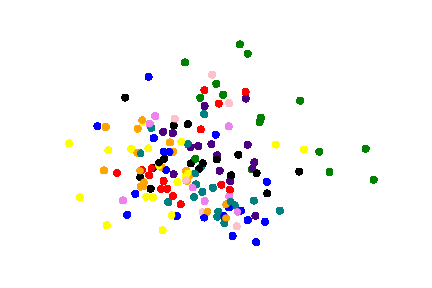
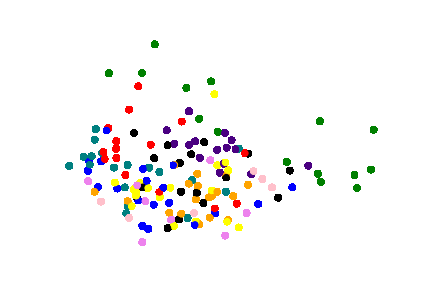
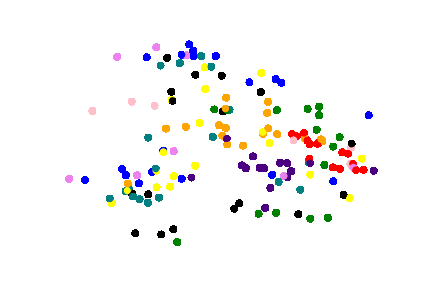

In [13]:
net.predict_pca(inputs, colors=colors)

The input PCA is just a 2D representation of the input patterns. Since this network isn't trained, the colors appear in largely random locations.

Now we train the network. In this example, we use the `save=50` parameter to save the weights at every 50 epochs (and once at the beginning).

In [14]:
history = net.fit(
    inputs, targets, 
    batch_size=16, 
    shuffle=True,
    epochs=600, 
    accuracy=1.0, 
    patience=30, 
    report_rate=10,
    validation_split=0.2,
    save=50,
)

Epoch 600/600 loss: 0.051002275198698044 - tolerance_accuracy: 0.96875 - val_loss: 0.31035324931144714 - val_tolerance_accuracy: 0.9375



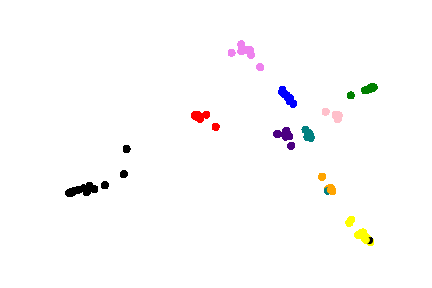
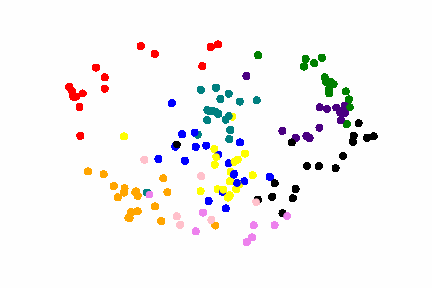
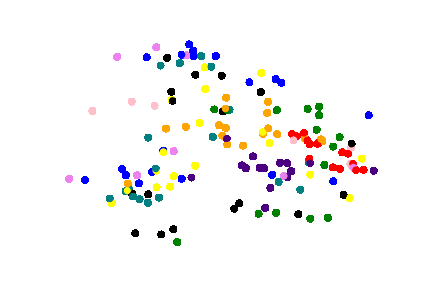

Above is epoch 600; press enter to continue:  


In [15]:
for epoch, weights in net.get_weights_from_history():
    net.set_weights(weights)
    net.predict_pca(inputs, colors=colors, scale=0.3, set_pca_spaces=False)
    input("Above is epoch %s; press enter to continue: " % epoch)

# Testing the trained network


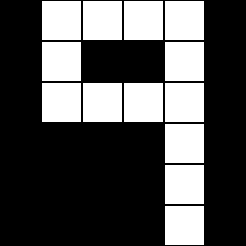

press enter 


In [20]:
for pattern in inputs[0:20]:
    net.take_picture(pattern)
    input("press enter")

# Analyzing the hidden layer representations

In [22]:
from scipy.cluster import hierarchy

In [23]:
labelList = [str(v) for v in range(10)]

In [24]:
hidden_raw = net.predict_to(inputs, "hidden")

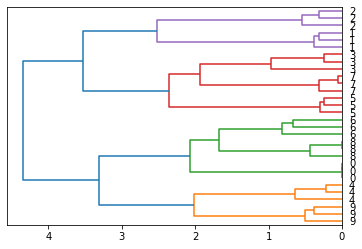

In [25]:
result = hierarchy.dendrogram(
    hierarchy.linkage(hidden_raw[30:60],method='ward'),
    orientation="left",
    labels=labelList*3)

Which digits are clustered together?  Does this make sense based on how similar they look?

# Testing noisy digits

In [26]:
from ipycanvas import Canvas, hold_canvas
import numpy as np

In [27]:
class ImageEditor(Canvas):
    def __init__(self, width=200, height=200, grid=(6, 6), data=None):
        super().__init__(width=width, height=height)
        self.x_size = width / grid[0]
        self.y_size = height / grid[1]
        self.state = "up"
        if data is None:
            self.self.data = np.zeros(grid)
        else:
            self.data = data.reshape(grid).copy()

        for col in range(grid[0]):
            for row in range(grid[1]):
                if self.data[row][col] == 0:
                    self.fill_style = "#000000"
                else:
                    self.fill_style = "#FFFFFF"
                self.fill_rect(col * self.x_size, 
                               row * self.y_size, 
                               self.x_size, 
                               self.y_size)
      
        self.stroke_style = '#749cb8'
        self.line_width = 1
        self.rect(1, 1, width - 1, height - 1)
        self.stroke()

        self.on_mouse_down(self.on_my_mouse_down)

    def on_my_mouse_down(self, x, y):
        with hold_canvas(self):
            x_pos = int(x // self.x_size)
            y_pos = int(y // self.y_size)
            if self.data[y_pos][x_pos] == 0:
                self.data[y_pos][x_pos] = 1
                self.fill_style = "#FFFFFF"
            else:
                self.data[y_pos][x_pos] = 0
                self.fill_style = "#000000"
            self.fill_rect(x_pos * self.x_size, 
                           y_pos * self.y_size, 
                           self.x_size, self.y_size)


In [28]:
c = ImageEditor(data=inputs[0])

In [29]:
c

ImageEditor(height=200, width=200)


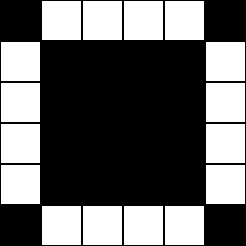

In [30]:
net.take_picture(c.data.reshape(36))